2017-11-28 20:45:59.185155
2017-11-28 20:46:00.476194
Runtime: 0:00:01.291039


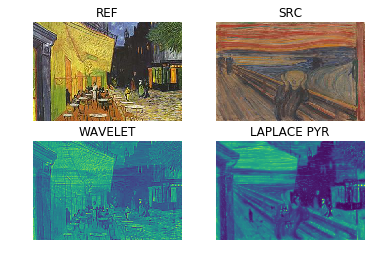

2017-11-28 20:45:59.185155
2017-11-28 20:46:01.833984
Runtime: 0:00:02.648829


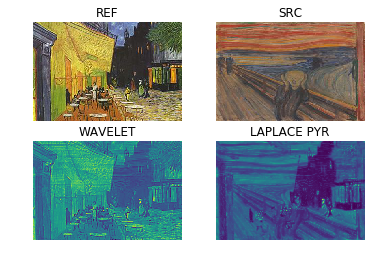

2017-11-28 20:45:59.185155
2017-11-28 20:46:03.221183
Runtime: 0:00:04.036028


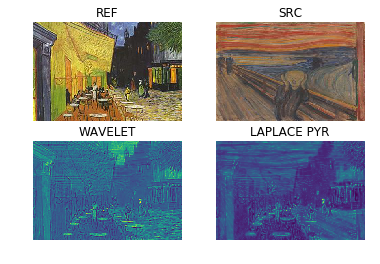

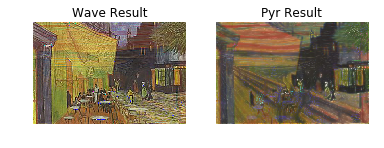

2017-11-28 20:46:03.726685
2017-11-28 20:46:04.791658
Runtime: 0:00:01.064973


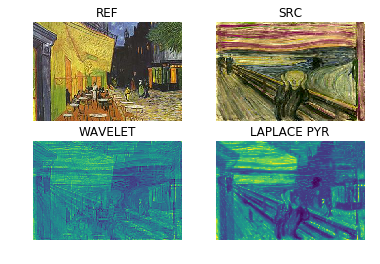

2017-11-28 20:46:03.726685
2017-11-28 20:46:06.323810
Runtime: 0:00:02.597125


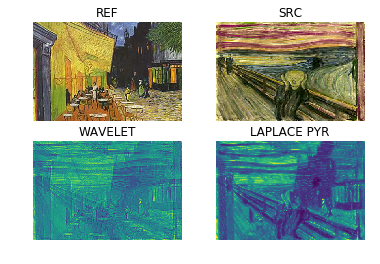

2017-11-28 20:46:03.726685


/home/wanghan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in divide
/home/wanghan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


2017-11-28 20:46:07.803989
Runtime: 0:00:04.077304


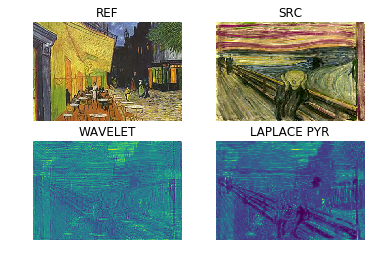

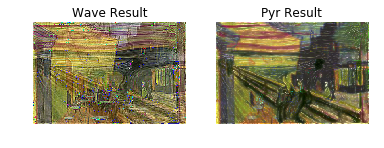

In [1]:
# -*- coding: utf-8 -*-
"""
Created by Wang Han on 2017/11/28 10:46.
E-mail address is hanwang.0501@gmail.com.
Copyright © 2017 Wang Han. SCU. All Rights Reserved.
"""

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import datetime
import pywt

# 以下强行用Python宏定义变量
half_window_size = 9
ref_image_path = 'images/input/1.jpg'
src_image_path = 'images/input/5.jpg'
''''' 
来自敬忠良，肖刚，李振华《图像融合——理论与分析》P85：基于像素清晰度的融合规则 
1，用Laplace金字塔或者是小波变换，将图像分解成高频部分和低频部分两个图像矩阵 
2，以某个像素点为中心开窗，该像素点的清晰度定义为窗口所有点((高频/低频)**2).sum() 
3，目前感觉主要的问题在于低频 
4，高频取清晰度图像中较大的那个图的高频图像像素点 
5，算法优化后速度由原来的2min.44s.变成9s.305ms. 
补充：书上建议开窗大小10*10，DWT取3层，Laplace金字塔取2层 
'''


# 打开图片
def img_open(ref_image_path, src_image_path):
    ref_image = Image.open(ref_image_path)
    src_image = Image.open(src_image_path)
    src_image = src_image.resize(ref_image.size)
    ref_image_array = np.array(ref_image)
    src_image_array = np.array(src_image)
    return ref_image_array, src_image_array


# 严格的变换尺寸
def _same_size(img_std, img_cvt):
    x, y = img_std.shape
    pic_cvt = Image.fromarray(img_cvt)
    pic_cvt = pic_cvt.resize((y, x))
    return np.array(pic_cvt)


# 小波变换的层数不能太高，Image模块的resize不能变换太小的矩阵，不相同大小的矩阵在计算对比度时会数组越界
def get_wave_img(ref_img, src_img):
    ref_img_wave = pywt.wavedec2(ref_img, 'haar', level=2)
    src_img_wave = pywt.wavedec2(src_img, 'haar', level=2)
    low_ref = ref_img_wave[0]
    low_src = src_img_wave[0]
    # 以下处理低频
    low_ref_weight, low_src_weight = get_variance_weight(low_ref, low_src)
    low_fusion = low_ref_weight * low_ref + low_src_weight * low_src
    # 以下处理高频
    for hi in range(1, 3):
        wave_rec = []
        for high_ref, high_src in zip(ref_img_wave[hi], src_img_wave[hi]):
            high_fusion = np.zeros(high_ref.shape)
            contrast_ref = get_contrast_img(low_ref, high_ref)
            contrast_src = get_contrast_img(low_src, high_src)
            row, col = high_ref.shape
            for i in range(row):
                for j in range(col):
                    if contrast_ref[i, j] > contrast_src[i, j]:
                        high_fusion[i, j] = high_ref[i, j]
                    else:
                        high_fusion[i, j] = high_src[i, j]
            wave_rec.append(high_fusion)
        recwave = (low_fusion, tuple(wave_rec))
        low_fusion = pywt.idwt2(recwave, 'haar')
        low_ref = low_fusion
        low_src = low_fusion
    return low_fusion


# 求Laplace金字塔
def get_laplace_pyr(img):
    first_level = img.copy()
    second_level = cv2.pyrDown(first_level)
    low_freq = cv2.pyrUp(second_level)
    high_freq = cv2.subtract(first_level, _same_size(first_level, low_freq))
    return low_freq, high_freq


# 计算对比度，优化后不需要这个函数了，扔在这里看看公式就行
def _get_contrast_value(high_win, low_win):
    row, col = high_win.shape
    contrast_value = 0.00
    for i in range(row):
        for j in range(col):
            contrast_value += (float(high_win[i, j]) / low_win[i, j])**2
    return contrast_value


# 先求出每个点的(hi/lo)**2，再用numpy的sum（C语言库）求和
def get_contrast_img(low, high):
    row, col = low.shape
    if low.shape != high.shape:
        low = _same_size(high, low)
    contrastImg = np.zeros((row, col))
    contrastVal = (high / low)**2
    for i in range(row):
        for j in range(col):
            up = i - half_window_size if i - half_window_size > 0 else 0
            down = i + half_window_size if i + half_window_size < row else row
            left = j - half_window_size if j - half_window_size > 0 else 0
            right = j + half_window_size if j + half_window_size < col else col
            contrastWindow = contrastVal[up:down, left:right]
            contrastImg[i, j] = contrastWindow.sum()
    return contrastImg


# 计算方差权重比
def get_variance_weight(ref_img, src_img):
    ref_imgMean, ref_imgVar = cv2.meanStdDev(ref_img)
    src_imgMean, src_imgVar = cv2.meanStdDev(src_img)
    ref_imgWeight = float(ref_imgVar) / (ref_imgVar + src_imgVar)
    src_imgWeight = float(src_imgVar) / (ref_imgVar + src_imgVar)
    return ref_imgWeight, src_imgWeight


# 函数返回融合后的图像矩阵
def get_pyr_fusion(ref_img, src_img):
    low_ref, high_ref = get_laplace_pyr(ref_img)
    low_src, high_src = get_laplace_pyr(src_img)
    contrast_ref = get_contrast_img(low_ref, high_ref)
    contrast_src = get_contrast_img(low_src, high_src)
    row, col = low_ref.shape
    highFusion = np.zeros((row, col))
    lowFusion = np.zeros((row, col))
    # 开始处理低频
    # ref_imgWeight,src_imgWeight=getVarianceWeight(low_ref,low_src)
    for i in range(row):
        for j in range(col):
            # lowFusion[i,j]=low_ref[i,j]*ref_imgWeight+low_src[i,j]*src_imgWeight
            lowFusion[i, j] = low_ref[
                i, j] if low_ref[i, j] < low_src[i, j] else low_src[i, j]
            # 开始处理高频
    for i in range(row):
        for j in range(col):
            highFusion[i, j] = high_ref[
                i, j] if contrast_ref[i, j] > contrast_src[i, j] else high_src[
                    i, j]
            # 开始重建
    fusionResult = cv2.add(highFusion, lowFusion)
    return fusionResult


# 绘图函数
def get_plot(ref_img, src_img, result):
    plt.subplot(131)
    plt.imshow(ref_img, cmap='gray')
    plt.title('src1')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(src_img, cmap='gray')
    plt.title('src2')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(result, cmap='gray')
    plt.title('result')
    plt.axis('off')
    plt.show()


# 画四张图的函数，为了方便同时比较
def cmp_plot(ref_img, src_img, wave, pyr):
    plt.subplot(221)
    plt.imshow(ref_img)
    plt.title('REF')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(src_img)
    plt.title('SRC')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(wave)
    plt.title('WAVELET')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(pyr)
    plt.title('LAPLACE PYR')
    plt.axis('off')
    plt.show()


def plot_result(waveResult_rgb, pyrResult_rgb):
    plt.subplot(121)
    plt.imshow(waveResult_rgb)
    plt.title('Wave Result')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(pyrResult_rgb)
    plt.title('Pyr Result')
    plt.axis('off')
    plt.show()


def reinhard(ref_image, src_image):
    def get_mean_and_std(lab_image):
        L_M_S_mean = np.zeros((3, 1))
        for idx in range(len(L_M_S_mean)):
            L_M_S_mean[idx] = np.mean(lab_image[:, :, idx])
        L_M_S_std = np.zeros((3, 1))
        for idx in range(len(L_M_S_std)):
            L_M_S_std[idx] = np.std(lab_image[:, :, idx])
        return L_M_S_mean, L_M_S_std

    ref_image_lab = cv2.cvtColor(ref_image, cv2.COLOR_BGR2LAB)
    src_image_lab = cv2.cvtColor(src_image, cv2.COLOR_BGR2LAB)
    mean1, std1 = get_mean_and_std(ref_image_lab)
    mean2, std2 = get_mean_and_std(src_image_lab)
    res_lab = np.zeros(ref_image.shape)
    width, height, depth = ref_image.shape
    for idx in range(3):
        res_lab[:, :, idx] = (src_image_lab[:, :, idx] - mean2[idx]) * (
            std1[idx] / std2[idx]) + mean1[idx]
        res_lab[:, :, idx][res_lab[:, :, idx] > 255] = 255
        res_lab[:, :, idx][res_lab[:, :, idx] < 0] = 0
    res_rgb = cv2.cvtColor(res_lab.astype('uint8'), cv2.COLOR_LAB2BGR)
    return res_rgb


def run_test1(ref_image=ref_image_path, src_image=src_image_path, isplot=True):
    ref_image_rgb, src_image_rgb = img_open(ref_image, src_image)
    beginTime = datetime.datetime.now()
    waveResult_rgb = np.empty(src_image_rgb.shape, 'uint8')
    pyrResult_rgb = np.empty(src_image_rgb.shape, 'uint8')
    for i in range(3):
        print(beginTime)
        waveResult = get_wave_img(ref_image_rgb[:, :, i],
                                  src_image_rgb[:, :, i])
        pyrResult = get_pyr_fusion(ref_image_rgb[:, :, i],
                                   src_image_rgb[:, :, i])
        endTime = datetime.datetime.now()
        print(endTime)
        print('Runtime: ' + str(endTime - beginTime))
        if isplot:
            cmp_plot(ref_image_rgb, src_image_rgb, waveResult, pyrResult)
        waveResult_rgb[:, :, i] = waveResult
        pyrResult_rgb[:, :, i] = pyrResult
    return waveResult_rgb, pyrResult_rgb


def runTest2(ref_image=ref_image_path, src_image=src_image_path, isplot=True):
    ref_image_rgb, src_image_rgb = img_open(ref_image, src_image)
    beginTime = datetime.datetime.now()
    src_image_rgb = reinhard(ref_image_rgb, src_image_rgb)
    waveResult_rgb = np.empty(src_image_rgb.shape, 'uint8')
    pyrResult_rgb = np.empty(src_image_rgb.shape, 'uint8')
    for i in range(3):
        print(beginTime)
        waveResult = get_wave_img(ref_image_rgb[:, :, i],
                                  src_image_rgb[:, :, i])
        pyrResult = get_pyr_fusion(ref_image_rgb[:, :, i],
                                   src_image_rgb[:, :, i])
        endTime = datetime.datetime.now()
        print(endTime)
        print('Runtime: ' + str(endTime - beginTime))
        if isplot:
            cmp_plot(ref_image_rgb, src_image_rgb, waveResult, pyrResult)
        waveResult_rgb[:, :, i] = waveResult
        pyrResult_rgb[:, :, i] = pyrResult
    return waveResult_rgb, pyrResult_rgb


if __name__ == '__main__':
    waveResult_rgb1, pyrResult_rgb1, = run_test1()
    plot_result(waveResult_rgb1, pyrResult_rgb1)
    waveResult_rgb2, pyrResult_rgb2, = runTest2()
    plot_result(waveResult_rgb2, pyrResult_rgb2)